In [1]:
import qutip as q
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

from animation import plot_cavity_evolution
from definitions import *

from timing import Hcoeff_list

%load_ext line_profiler

## Hamiltonians with activation functions for the gates
$H = H_0 + f(t)U_1+ g(t)V_1 + h(t)W_1$ 

where 
- $H_0=\hbar\frac{\omega_a}{2}\sigma_z + \hbar\omega_c a^\dagger a$
- $U_k = u_k \hat{x}\hat{\sigma_y}$
- $V_k = v_k \hat{p}\hat{\sigma_x}$
- $W_k = w_k \hat{x}\hat{\sigma_y}$

In [47]:
#Setup simulation parameters 

#Number of steps
M = 2

#Activation functions
T = 2
dT = T
Tdelay = 6*T+3*dT 
z = 100
activation_settings = {'M': M, 'T': T, 'dT': dT, 'Tdelay': Tdelay, 'z': z}


#Losses
gamma_bl = 0
gamma_bdp = 0
gamma_c = 0
nbar = 0
gamma_ql = 0
gamma_qdp = 0

noise_sources = {'boson loss': gamma_bl, 'boson dephasing': gamma_bdp, 'boson heating': [gamma_c, nbar], 
         'qubit loss': gamma_ql, 'qubit dephasing': gamma_qdp}


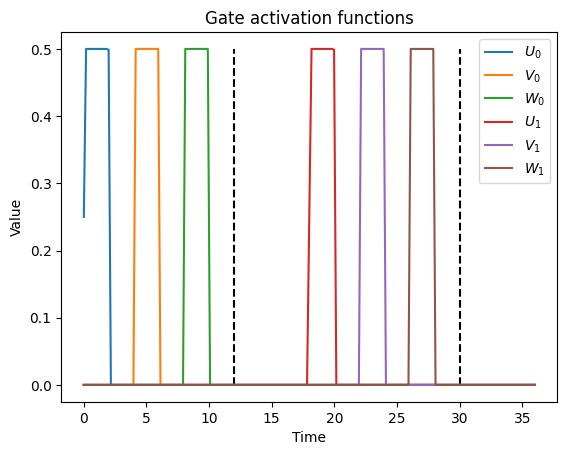

In [48]:
def plot_activation_funcs(ax, settings, times):
    
    M, T, dT, Tdelay, z = settings.values()
    
    Hcoeffs = Hcoeff_list(settings)
    labels = [f'$U_{k}$' if g == 0 else f'$V_{k}$' if g == 1 else f'$W_{k}$' for k in range(M) for g in range(3)]

    
    for i, fun in enumerate(Hcoeffs):
        ax.plot(t, fun(t), label = labels[i] )

    ax.legend()
    ax.set_title('Gate activation functions')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')

fig, ax = plt.subplots(1,)
#Define times to show the Wigner function 

t_wig = Tdelay* np.arange(1,M+1) - 3*T
for t in t_wig:
    ax.vlines(t, 0, 0.5, color = 'k',linestyle='dashed')
    
t = np.linspace(0,Tdelay*M,201)
plot_activation_funcs(ax, activation_settings, t)

In [49]:
def GKP_generator(zeta, settings, alpha=0, noise_sources = False, t = np.linspace(0,Tdelay*M,201)):

    #H0 = oma/2*sz + omc*ad*a
    H0 = I
    
    Hlist = get_Hlist(M)
    Hcoeffs = Hcoeff_list(settings)
    
    Htimedep =  list(map(list, zip(Hlist, Hcoeffs)))

    H = [H0, *Htimedep]
    if noise_sources:
        gamma_bl, gamma_bdp, (gamma_c, nbar), gamma_ql, gamma_qdp = noise_sources.values()
        
        c_ops = [np.sqrt(gamma_bl)*a, #Boson loss
                 np.sqrt(gamma_bdp)*(a*ad + ad*a), #Boson dephasing
                 np.sqrt(gamma_c*(nbar+1))*a, #Boson heating 1
                 np.sqrt(gamma_c*nbar)*ad, #Boson heating 2
                 np.sqrt(gamma_ql)*sm, #Qubit decay
                 np.sqrt(gamma_qdp)*sz] #Qubit dephasing
    else:
        c_ops = []
    
    #Initial state (squeeze the coherent state with zero displacement)
    rho0 = q.tensor(q.basis(2,0), q.squeeze(N, zeta) @ q.coherent(N, alpha))
    res = q.mesolve(H, rho0, c_ops = c_ops, tlist= t)

    return res

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (8,4))

axes[0].plot(res.times, [q.expect(ad*a, s) for s in res.states], linestyle = 'dashed', label ='cavity photon number')
axes[0].set_xlabel(r'Time, $t$')
axes[0].set_ylabel(r'$\langle\hat{a}^\dagger \hat{a}\rangle$')
axes[0].legend()


for i, s in enumerate(res.states): 

    rho_cavity = s.ptrace(1)
    W_cavity = q.wigner(rho_cavity, x,x)
    im1 = axes[0].scatter(res.times[i], q.expect(ad*a,s), color = 'b')
    
    im2 = plot_wigner(axes[1], W_cavity, x, x)
    
    ims.append([im1,im2])

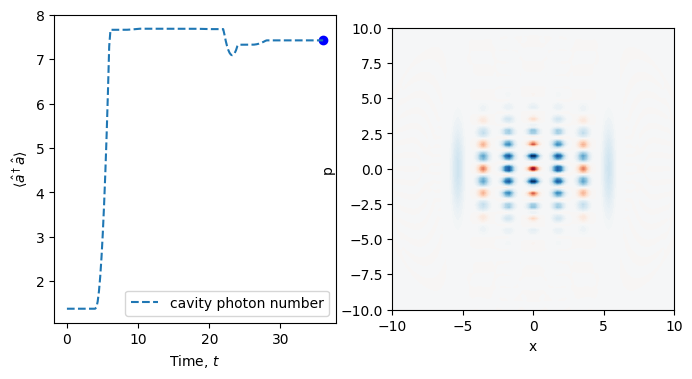

In [51]:
res = GKP_generator(1, activation_settings, 0)
ani = plot_cavity_evolution(res)
HTML(ani.to_html5_video())

In [ ]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Click me.")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print('Button clicked.')
button.on_click(on_button_clicked)


In [ ]:
#ani = plot_cavity_evolution(GKP_generator(0,1))
#HTML(ani.to_html5_video())

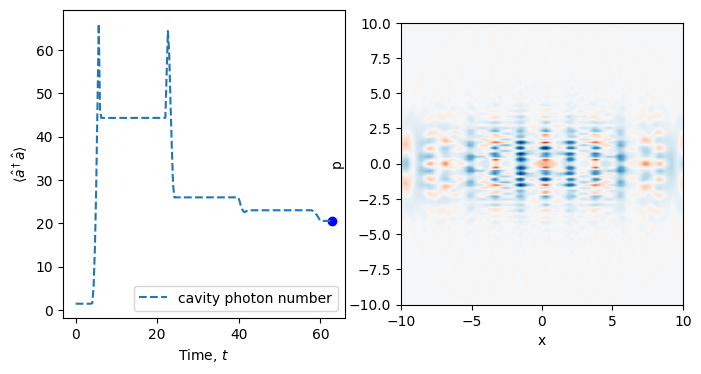

In [ ]:
def plot_cavity_evolution_test(res, x = np.linspace(-10,10,100)):
    ims = []
    fig, axes = plt.subplots(1, 2, figsize = (8,4))

    axes[0].plot(res.times, [q.expect(ad*a, s) for s in res.states], linestyle = 'dashed', label ='cavity photon number')
    axes[0].set_xlabel(r'Time, $t$')
    axes[0].set_ylabel(r'$\langle\hat{a}^\dagger \hat{a}\rangle$')
    axes[0].legend()
    

    for i, s in enumerate(res.states): 

        rho_cavity = s.ptrace(1)
        W_cavity = q.wigner(rho_cavity, x,x)
        im1 = axes[0].scatter(res.times[i], q.expect(ad*a,s), color = 'b')
        
        im2 = plot_wigner(axes[1], W_cavity, x, x)
        
        ims.append([im1,im2])

    return ArtistAnimation(fig, ims, interval=50, blit=True)

In [ ]:
%lprun -f GKP_generator GKP_generator(0,1)

In [ ]:
%lprun -f plot_cavity_evolution plot_cavity_evolution(res)